# Initial Structure to Relaxed Structure (IS2RS) 

We approach the IS2RS task by using a pre-trained S2EF model to iteratively run a structure optimization to arrive at a relaxed structure. While the majority of approaches for this task do this iteratively, we note it's possible to train a model to directly predict relaxed structures.

## Steps for making IS2RS predictions
1) Define or load a configuration (config), which includes the following
* task with relaxation dataset information
* model
* optimizer
* dataset
* trainer

2) Create a ForcesTrainer object

3) Train a S2EF model or load an existing S2EF checkpoint

4) Run relaxations

**Note** For this task we'll be using a publicly released pre-trained checkpoint of our best model to perform relaxations.

#### Imports

In [ ]:
from ocpmodels import models
from ocpmodels.common import logger
from ocpmodels.common.utils import setup_logging
from ocpmodels.datasets import TrajectoryLmdbDataset
from ocpmodels.trainers import ForcesTrainer

setup_logging()

import numpy as np

### Dataset

The IS2RS task requires an additional relaxation dataset to be defined - `relax_dataset`. This dataset is read in similar to the IS2RE dataset - requiring an LMDB file. The same datasets are used for the IS2RE and IS2RS tasks.

In [ ]:
%%bash
mkdir data
cd data
wget -q -nc http://dl.fbaipublicfiles.com/opencatalystproject/data/tutorial_data.tar.gz -O tutorial_data.tar.gz
tar -xzvf tutorial_data.tar.gz

In [ ]:
train_src = "data/s2ef/train_100"
val_src = "data/s2ef/val_20"
relax_dataset = "data/is2re/val_20/data.lmdb"

### Download pretrained checkpoint

In [ ]:
!wget -q https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_08/s2ef/gemnet_t_direct_h512_all.pt
checkpoint_path = "/content/ocp/gemnet_t_direct_h512_all.pt"

### Define the Config

Running an iterative S2EF model for the IS2RS task can be run from any S2EF config given the following additions to the `task` portion of the config:

* relax_dataset - IS2RE LMDB dataset
* *write_pos* - Whether to save out relaxed positions
* *relaxation_steps* - Number of optimization steps to run
* *relax_opt* - Dictionary of optimizer settings. Currently only LBFGS supported
  * *maxstep* - Maximum distance an optimization is allowed to make
  * *memory* - Memory history to use for LBFGS
  * *damping* - Calculated step is multiplied by this factor before updating positions
  * *alpha* - Initial guess for the Hessian
  * *traj_dir* - If specified, directory to save out the full ML relaxation as an ASE trajectory. Useful for debugging or visualizing results.
* *num_relaxation_batches* - If specified, relaxations will only be run for a subset of the relaxation dataset. Useful for debugging or wanting to visualize a few systems.

A sample relaxation config can be found [here](https://github.com/Open-Catalyst-Project/ocp/blob/1044e311182c1120c6e6d137ce6db3f445148973/configs/s2ef/2M/dimenet_plus_plus/dpp_relax.yml#L24-L33).
   

In [ ]:
# Task
task = {
    "dataset": "trajectory_lmdb",  # dataset used for the S2EF task
    "description": "Regressing to energies and forces for DFT trajectories from OCP",
    "type": "regression",
    "metric": "mae",
    "labels": ["potential energy"],
    "grad_input": "atomic forces",
    "train_on_free_atoms": True,
    "eval_on_free_atoms": True,
    "relax_dataset": {"src": relax_dataset},
    "write_pos": True,
    "relaxation_steps": 200,
    "num_relaxation_batches": 1,
    "relax_opt": {
        "maxstep": 0.04,
        "memory": 50,
        "damping": 1.0,
        "alpha": 70.0,
        "traj_dir": "ml-relaxations/is2rs-test",
    },
}
# Model
model = {
    "name": "gemnet_t",
    "num_spherical": 7,
    "num_radial": 128,
    "num_blocks": 3,
    "emb_size_atom": 512,
    "emb_size_edge": 512,
    "emb_size_trip": 64,
    "emb_size_rbf": 16,
    "emb_size_cbf": 16,
    "emb_size_bil_trip": 64,
    "num_before_skip": 1,
    "num_after_skip": 2,
    "num_concat": 1,
    "num_atom": 3,
    "cutoff": 6.0,
    "max_neighbors": 50,
    "rbf": {"name": "gaussian"},
    "envelope": {
        "name": "polynomial",
        "exponent": 5,
    },
    "cbf": {"name": "spherical_harmonics"},
    "extensive": True,
    "otf_graph": False,
    "output_init": "HeOrthogonal",
    "activation": "silu",
    "scale_file": "configs/s2ef/all/gemnet/scaling_factors/gemnet-dT.json",
    "regress_forces": True,
    "direct_forces": True,
}
# Optimizer
optimizer = {
    "batch_size": 1,  # originally 32
    "eval_batch_size": 1,  # originally 32
    "num_workers": 2,
    "lr_initial": 5.0e-4,
    "optimizer": "AdamW",
    "optimizer_params": {"amsgrad": True},
    "scheduler": "ReduceLROnPlateau",
    "mode": "min",
    "factor": 0.8,
    "ema_decay": 0.999,
    "clip_grad_norm": 10,
    "patience": 3,
    "max_epochs": 1,  # used for demonstration purposes
    "force_coefficient": 100,
}
# Dataset
dataset = [
    {"src": train_src, "normalize_labels": False},  # train set
    {"src": val_src},  # val set (optional)
]

### Create the trainer

In [ ]:
trainer = ForcesTrainer(
    task=task,
    model=model,
    dataset=dataset,
    optimizer=optimizer,
    identifier="is2rs-example",
    run_dir="./",  # directory to save results if is_debug=False. Prediction files are saved here so be careful not to override!
    is_debug=False,  # if True, do not save checkpoint, logs, or results
    print_every=5,
    seed=0,  # random seed to use
    logger="tensorboard",  # logger of choice (tensorboard and wandb supported)
    local_rank=0,
    amp=True,  # use PyTorch Automatic Mixed Precision (faster training and less memory usage)
)

amp: true
cmd:
  checkpoint_dir: ./checkpoints/2022-10-28-20-09-36-is2rs-example
  commit: 6e750b2
  identifier: is2rs-example
  logs_dir: ./logs/tensorboard/2022-10-28-20-09-36-is2rs-example
  print_every: 5
  results_dir: ./results/2022-10-28-20-09-36-is2rs-example
  seed: 0
  timestamp_id: 2022-10-28-20-09-36-is2rs-example
dataset:
  normalize_labels: false
  src: data/s2ef/train_100
gpus: 1
logger: tensorboard
model: gemnet_t
model_attributes:
  activation: silu
  cbf:
    name: spherical_harmonics
  cutoff: 6.0
  direct_forces: true
  emb_size_atom: 512
  emb_size_bil_trip: 64
  emb_size_cbf: 16
  emb_size_edge: 512
  emb_size_rbf: 16
  emb_size_trip: 64
  envelope:
    exponent: 5
    name: polynomial
  extensive: true
  max_neighbors: 50
  num_after_skip: 2
  num_atom: 3
  num_before_skip: 1
  num_blocks: 3
  num_concat: 1
  num_radial: 128
  num_spherical: 7
  otf_graph: false
  output_init: HeOrthogonal
  rbf:
    name: gaussian
  regress_forces: true
  scale_file: configs/s2e

### Load the best checkpoint


In [ ]:
trainer.load_checkpoint(checkpoint_path=checkpoint_path)

### Run relaxations

We run a full relaxation for a single batch of our relaxation dataset (`num_relaxation_batches=1`).

In [ ]:
trainer.run_relaxations()

  0%|          | 0/20 [00:00<?, ?it/s]/content/ocp/ocpmodels/models/gemnet/gemnet.py:373: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  neighbors_new // 2,
/content/ocp/ocpmodels/models/gemnet/gemnet.py:467: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  block_sizes = neighbors // 2
  5%|▌         | 1/20 [00:10<03:23, 10.72s/it]


### Visualize ML-driven relaxations

Following our earlier [visualization steps](#data-description), we can plot our ML-generated relaxations.

In [ ]:
import glob
import random

import ase.io
import matplotlib
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms

params = {
    "axes.labelsize": 14,
    "font.size": 14,
    "font.family": " DejaVu Sans",
    "legend.fontsize": 20,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "axes.labelsize": 25,
    "axes.titlesize": 25,
    "text.usetex": False,
    "figure.figsize": [12, 12],
}
matplotlib.rcParams.update(params)

'ml-relaxations/is2rs-test/1700380.traj'

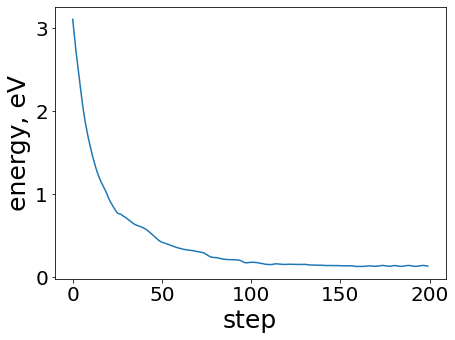

In [ ]:
system = glob.glob("ml-relaxations/is2rs-test/*.traj")[0]
ml_trajectory = ase.io.read(system, ":")

energies = [atom.get_potential_energy() for atom in ml_trajectory]

plt.figure(figsize=(7, 5))
plt.plot(range(len(energies)), energies)
plt.xlabel("step")
plt.ylabel("energy, eV")
system

Qualitatively, the ML relaxation is behaving as expected - decreasing energies over the course of the relaxation.

<AxesSubplot: title={'center': 'ml-final'}>

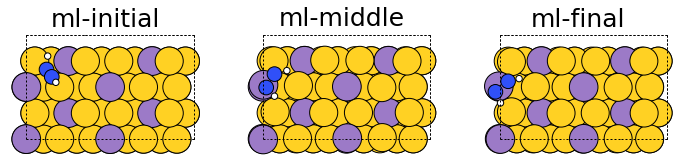

In [ ]:
fig, ax = plt.subplots(1, 3)
labels = ["ml-initial", "ml-middle", "ml-final"]
for i in range(3):
    ax[i].axis("off")
    ax[i].set_title(labels[i])

ase.visualize.plot.plot_atoms(
    ml_trajectory[0],
    ax[0],
    radii=0.8,
    # rotation=("-75x, 45y, 10z")) # uncomment to visualize at different angles
)
ase.visualize.plot.plot_atoms(
    ml_trajectory[100],
    ax[1],
    radii=0.8,
    # rotation=("-75x, 45y, 10z") # uncomment to visualize at different angles
)
ase.visualize.plot.plot_atoms(
    ml_trajectory[-1],
    ax[2],
    radii=0.8,
    # rotation=("-75x, 45y, 10z"), # uncomment to visualize at different angles
)

Qualitatively, the generated structures seem reasonable with no obvious issues we had previously mentioned to look out for.